This notebook was used to engineer environmental features and use those features to understand the influence of the local environment on elemental composition. 

In [11]:
library(tidyverse)
library(lubridate)
library(lmerTest)
library(corrplot)
options(contrasts = c("contr.sum","contr.poly"))

corrplot 0.84 loaded


In [2]:
weather_df <- read.csv('../../2017_2020_weather_station_metric.csv')
colnames(weather_df) <- c('MONTH', 'DAY', 'YEAR', 'maxT', 'minT', 'avgT', 
                          'maxWind', 'precip', 'maxP', 'minP', 'avgDP', 
                          'maxDP', 'minDP', 'evap', 'totalRad')
weather_df$Date <- paste(weather_df$YEAR, weather_df$MONTH, weather_df$DAY, sep='-')
weather_df$Date <- as.Date(weather_df$Date)
head(weather_df)

MONTH,DAY,YEAR,maxT,minT,avgT,maxWind,precip,maxP,minP,avgDP,maxDP,minDP,evap,totalRad,Date
1,1,2017,11.6,-5.4,3.2,8.9,0.00,1016,1012,-1.2,5.6,-7.5,1.131,7.84,2017-01-01
1,2,2017,10.9,6.1,8.3,7.2,1.27,1013,1008,7.7,10.0,5.6,0.350,3.06,2017-01-02
1,3,2017,10.0,-6.4,2.3,9.2,0.00,1024,1010,0.7,10.0,-10.4,0.253,1.02,2017-01-03
1,4,2017,-1.1,-10.5,-5.8,8.7,0.00,1026,1016,-13.2,-10.2,-15.7,0.870,10.74,2017-01-04
1,5,2017,-3.8,-12.2,-8.7,7.4,0.00,1024,1016,-12.3,-8.2,-17.9,0.316,3.34,2017-01-05
1,6,2017,-9.8,-15.6,-12.4,7.2,0.00,1032,1023,-18.0,-16.4,-20.1,0.424,6.12,2017-01-06


In [3]:
weather_df$MonthDay <- format(weather_df$Date, '%m-%d')
weather_df$MonthDay <- as.Date(paste(rep("1904", length(weather_df$Date)), month(weather_df$Date), day(weather_df$Date), sep='-'))

p1 <- ggplot(weather_df, aes(x=MonthDay, y=maxT, color=as.factor(year(Date)))) + 
  geom_point() + 
  stat_smooth(method='loess') + 
  scale_x_date(labels = scales::date_format("%b")) + 
  theme_bw()

p2 <- ggplot(weather_df, aes(x=MonthDay, y=maxWind, color=as.factor(year(Date)))) + 
  geom_point() + 
  stat_smooth(method='loess') + 
  scale_x_date(labels = scales::date_format("%b")) + 
  theme_bw()

p3 <- ggplot(weather_df, aes(x=MonthDay, y=maxP, color=as.factor(year(Date)))) + 
  geom_point() + 
  stat_smooth(method='loess') + 
  scale_x_date(labels = scales::date_format("%b")) + 
  theme_bw()

pdf('1719_weather_example.pdf', height=4.2, width=12)
  ggpubr::ggarrange(p1, p2, p3, ncol=3, nrow=1, common.legend=T)
dev.off()



`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


pdf 
  2

## Feature Engineering

### 14 days

In [4]:
colnames(weather_df)

[1] "MONTH"    "DAY"      "YEAR"     "maxT"     "minT"     "avgT"    
 [7] "maxWind"  "precip"   "maxP"     "minP"     "avgDP"    "maxDP"   
[13] "minDP"    "evap"     "totalRad" "Date"     "MonthDay"

In [27]:
dates = c('2017-05-22', '2017-07-30', '2017-09-25', 
          '2018-05-30', '2018-08-01', '2018-09-17', 
          '2019-05-23', '2019-08-05', '2019-09-17')

offset <- 14
new_meta <- list()

for (d in dates){
    idx <- which(weather_df$Date == as.Date(d)) - 1 # -1 excludes day of sampling
    meta <- c()
    sub <- weather_df[((idx - offset):idx), ]
    meta <- c(meta, 
              mean(sub$maxT), mean(sub$minT), mean(sub$avgT),
              mean(sub$maxWind), sum(sub$precip),mean(sub$maxP), 
              mean(sub$minP), mean(sub$avgDP), mean(sub$maxDP), mean(sub$minDP),  
              sum(sub$totalRad),mean(sub$maxT - sub$minT), 
              mean(sub$maxP - sub$minP), mean(sub$maxDP - sub$minDP), mean(sub$evap))
    new_meta[[d]] <- meta
}

new_meta <- as.data.frame(t(as.data.frame(new_meta)))
dim(new_meta)
colnames(new_meta) <- c('avgmaxT_14', 'avgminT_14', 'avgavgT_14', 'avgmaxW_14', 'sumPrecip_14', 
                        'avgmaxP_14', 'avgminP_14', 'avgavgDP_14','avmaxDP_14','avgminDP_14' ,
                        'sumRad_14', 'avgdT_14', 'avgdP_14', 'avgdDP_14', 'avgEvap_14')
new_meta$Date <- as.Date(dates)
new_meta

[1]  9 15

,avgmaxT_14,avgminT_14,avgavgT_14,avgmaxW_14,sumPrecip_14,avgmaxP_14,avgminP_14,avgavgDP_14,avmaxDP_14,avgminDP_14,sumRad_14,avgdT_14,avgdP_14,avgdDP_14,avgEvap_14,Date
X2017.05.22,25.13333,13.20667,19.18000,10.666667,105.17,1016.067,1010.800,13.57333,17.34000,9.973333,300.17,11.92667,5.266667,7.366667,4.125533,2017-05-22
X2017.07.30,32.80667,19.72667,26.30667,7.020000,18.79,1018.867,1014.867,20.19333,23.19333,16.926667,320.19,13.08000,4.000000,6.266667,4.907867,2017-07-30
X2017.09.25,28.50667,14.98000,21.44667,8.053333,8.89,1017.800,1013.533,15.85333,18.79333,13.020000,262.75,13.52667,4.266667,5.773333,3.651467,2017-09-25
X2018.05.30,28.96667,16.12667,22.04000,8.620000,23.88,1016.800,1012.467,17.66000,21.14667,13.980000,288.12,12.84000,4.333333,7.166667,3.937467,2018-05-30
X2018.08.01,30.60000,17.32667,23.69333,8.293333,12.18,1018.600,1014.933,17.52667,21.31333,13.906667,254.41,13.27333,3.666667,7.406667,4.003533,2018-08-01
X2018.09.17,26.94000,17.30000,21.83333,6.833333,64.26,1019.867,1016.733,18.53333,21.10667,16.493333,230.34,9.64000,3.133333,4.613333,2.978467,2018-09-17
X2019.05.23,21.68000,11.01333,16.45333,10.680000,140.96,1015.467,1008.267,12.30667,16.42667,8.600000,241.40,10.66667,7.200000,7.826667,3.134933,2019-05-23
X2019.08.05,28.45333,17.46000,23.07333,8.213333,43.94,1021.067,1017.333,18.18000,21.17333,15.366667,292.13,10.99333,3.733333,5.806667,3.997667,2019-08-05
X2019.09.17,31.28000,18.86000,24.83333,8.160000,17.53,1020.800,1017.133,19.24667,22.29333,15.953333,289.21,12.42000,3.666667,6.340000,4.237133,2019-09-17


In [28]:
#new_meta <- merge(new_meta, weather_df[, c('Date', 'evap')], by='Date')

In [29]:
## correlation structure
weather_PCA <- new_meta %>% select(avgmaxT_14:avgEvap_14)
#pairs(weather_PCA)

In [30]:
# library(igraph)
library(corrplot)

# containNA <- function(vec){
#     if (sum(is.na(vec)) > 0){
#         return(1)
#     } else {
#         return(0)
#     }
# }

# make_network_diagram <- function(x) {
#     x <- cor(x)
#     res1 <- cor.mtest(x, conf.level = 0.95)
#     colnames(res1$p) <- colnames(x)
#     rownames(res1$p) <- rownames(x)
#     pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=dim(x)[2])
#     colnames(pmat.adj) <- colnames(x)
#     rownames(pmat.adj) <- rownames(x) 
#     screen_mat <- pmat.adj
#     screen_mat[screen_mat > 0.05] <- 0
#     x[screen_mat == 0] <- 0
#     g_raw <- graph_from_adjacency_matrix(x, mode='upper', weighted=T, diag=F)
#     g <- graph_from_adjacency_matrix(abs(x)^2, mode='upper', weighted=T, diag=F)
#     E(g)$color[E(g_raw)$weight > 0] <- 'skyblue1'
#     E(g)$color[E(g_raw)$weight < 0] <- 'salmon1'
#     plot(g, layout=layout.circle, edge.width=abs(E(g)$weight)*8, vertex.color='white')
# }


# make_network_diagram(weather_PCA)

In [31]:
colnames(weather_PCA)

[1] "avgmaxT_14"   "avgminT_14"   "avgavgT_14"   "avgmaxW_14"   "sumPrecip_14"
 [6] "avgmaxP_14"   "avgminP_14"   "avgavgDP_14"  "avmaxDP_14"   "avgminDP_14" 
[11] "sumRad_14"    "avgdT_14"     "avgdP_14"     "avgdDP_14"    "avgEvap_14"

In [32]:
colnames(weather_PCA) <- c('maxT', 'minT', 'avgT', 'maxW', 'sumPrecip', 'maxP', 'minP', 
                           'avgDP', 'maxDP', 'minDP', 'sumRad', 'dT', 'dP', 'dDP', 'Evap')

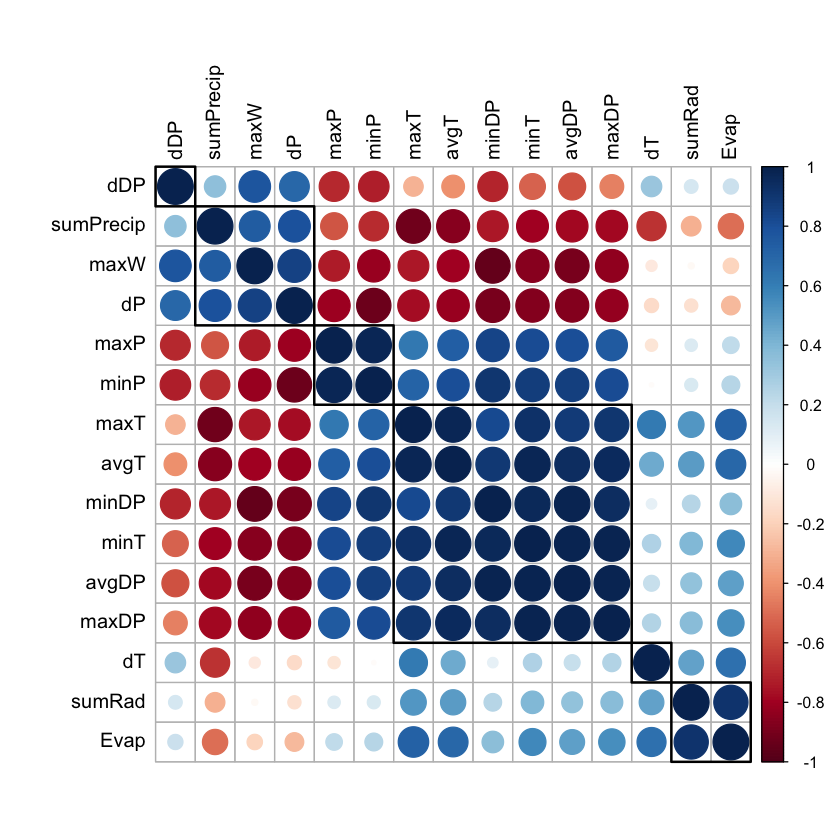

In [33]:
x <- cor(weather_PCA)
res1 <- cor.mtest(x, conf.level = 0.95)
# pdf('179_weather_correlations.pdf', height=8, width=8)
  corrplot(
      x, order = 'hclust', addrect = 6, tl.col='black', 
      #col=colorRampPalette(c("magenta4",'white',"royalblue4"))(200)
          )
# dev.off()

## 7 days

In [34]:
offset <- 7
new_meta_7 <- list()

for (d in dates){
    idx <- which(weather_df$Date == as.Date(d)) - 1 # -1 excludes day of sampling
    meta <- c()
    sub <- weather_df[((idx - offset):idx), ]
    meta <- c(meta, 
              mean(sub$maxT), mean(sub$minT), mean(sub$avgT),
              mean(sub$maxWind), sum(sub$precip),mean(sub$maxP), 
              mean(sub$minP), mean(sub$avgDP), mean(sub$maxDP), mean(sub$minDP),  
              sum(sub$totalRad),mean(sub$maxT - sub$minT), 
              mean(sub$maxP - sub$minP), mean(sub$maxDP - sub$minDP), mean(sub$evap))
    new_meta_7[[d]] <- meta
}

new_meta_7 <- as.data.frame(t(as.data.frame(new_meta_7)))
dim(new_meta_7)
colnames(new_meta_7) <- c('avgmaxT_07', 'avgminT_07', 'avgavgT_07', 'avgmaxW_07', 'sumPrecip_07', 
                        'avgmaxP_07', 'avgminP_07', 'avgavgDP_07','avmaxDP_07','avgminDP_07' ,
                        'sumRad_07', 'avgdT_07', 'avgdP_07', 'avgdDP_07', 'avgEvap_07')
new_meta_7$Date <- as.Date(dates)
new_meta_7

[1]  9 15

,avgmaxT_07,avgminT_07,avgavgT_07,avgmaxW_07,sumPrecip_07,avgmaxP_07,avgminP_07,avgavgDP_07,avmaxDP_07,avgminDP_07,sumRad_07,avgdT_07,avgdP_07,avgdDP_07,avgEvap_07,Date
X2017.05.22,25.1125,13.7000,19.4250,12.4000,71.38,1015.500,1009.250,13.6625,17.3625,9.8625,161.25,11.4125,6.250,7.5000,4.320625,2017-05-22
X2017.07.30,32.9000,20.3875,26.4375,7.6750,18.79,1017.750,1013.750,20.0500,22.5625,16.4875,161.41,12.5125,4.000,6.0750,4.732750,2017-07-30
X2017.09.25,29.6500,17.8625,23.4500,8.2375,8.89,1017.625,1013.250,18.5875,21.2375,16.4750,125.67,11.7875,4.375,4.7625,3.456125,2017-09-25
X2018.05.30,30.3625,16.7625,23.3125,7.7750,6.10,1016.750,1012.375,18.4625,21.7750,14.5625,160.69,13.6000,4.375,7.2125,4.235500,2018-05-30
X2018.08.01,29.4875,16.0750,22.6750,7.2625,10.41,1020.000,1016.625,16.1250,20.2625,11.8250,124.64,13.4125,3.375,8.4375,3.678875,2018-08-01
X2018.09.17,26.5375,15.5125,20.8750,5.3375,0.51,1020.000,1016.875,17.1500,19.7875,14.9250,135.69,11.0250,3.125,4.8625,3.087125,2018-09-17
X2019.05.23,24.5875,13.6500,19.2625,12.8875,119.12,1014.250,1006.125,14.5625,18.8375,10.7250,142.59,10.9375,8.125,8.1125,3.738750,2019-05-23
X2019.08.05,28.7625,18.9500,23.8000,8.1500,32.00,1019.750,1016.125,19.7250,22.2500,17.4500,136.56,9.8125,3.625,4.8000,3.524000,2019-08-05
X2019.09.17,31.0625,18.7375,24.7125,9.7500,17.53,1021.875,1018.125,18.5500,21.3250,14.9375,144.72,12.3250,3.750,6.3875,4.252500,2019-09-17


In [35]:
weather_PCA <- new_meta_7 %>% select(avgmaxT_07:avgEvap_07)
colnames(weather_PCA)

[1] "avgmaxT_07"   "avgminT_07"   "avgavgT_07"   "avgmaxW_07"   "sumPrecip_07"
 [6] "avgmaxP_07"   "avgminP_07"   "avgavgDP_07"  "avmaxDP_07"   "avgminDP_07" 
[11] "sumRad_07"    "avgdT_07"     "avgdP_07"     "avgdDP_07"    "avgEvap_07"

In [36]:
colnames(weather_PCA) <- c('maxT', 'minT', 'avgT', 'maxW', 'sumPrecip', 'maxP', 'minP', 
                           'avgDP', 'maxDP', 'minDP', 'sumRad', 'dT', 'dP', 'dDP', 'Evap')

In [37]:
x <- cor(weather_PCA)
res1 <- cor.mtest(x, conf.level = 0.95)
pdf('179_weather_correlations_vineid.pdf', height=8, width=8)
  corrplot(
      x, order = 'hclust', addrect = 6, tl.col='black', 
      #col=colorRampPalette(c("magenta4",'white',"royalblue4"))(200)
          )
dev.off()

pdf 
  2

## 3 days

In [38]:
offset <- 3
new_meta_3 <- list()

for (d in dates){
    idx <- which(weather_df$Date == as.Date(d)) - 1 # -1 excludes day of sampling
    meta <- c()
    sub <- weather_df[((idx - offset):idx), ]
    meta <- c(meta, 
              mean(sub$maxT), mean(sub$minT), mean(sub$avgT),
              mean(sub$maxWind), sum(sub$precip),mean(sub$maxP), 
              mean(sub$minP), mean(sub$avgDP), mean(sub$maxDP), mean(sub$minDP),  
              sum(sub$totalRad),mean(sub$maxT - sub$minT), 
              mean(sub$maxP - sub$minP), mean(sub$maxDP - sub$minDP), mean(sub$evap))
    new_meta_3[[d]] <- meta
}

new_meta_3 <- as.data.frame(t(as.data.frame(new_meta_3)))
dim(new_meta_3)
colnames(new_meta_3) <- c('avgmaxT_03', 'avgminT_03', 'avgavgT_03', 'avgmaxW_03', 'sumPrecip_03', 
                        'avgmaxP_03', 'avgminP_03', 'avgavgDP_03','avmaxDP_03','avgminDP_03' ,
                        'sumRad_03', 'avgdT_03', 'avgdP_03', 'avgdDP_03', 'avgEvap_03')
new_meta_3$Date <- as.Date(dates)
new_meta_3

[1]  9 15

,avgmaxT_03,avgminT_03,avgavgT_03,avgmaxW_03,sumPrecip_03,avgmaxP_03,avgminP_03,avgavgDP_03,avmaxDP_03,avgminDP_03,sumRad_03,avgdT_03,avgdP_03,avgdDP_03,avgEvap_03,Date
X2017.05.22,23.350,13.150,17.925,13.625,70.62,1017.50,1011.00,13.825,17.050,9.875,67.41,10.200,6.50,7.175,3.30250,2017-05-22
X2017.07.30,31.225,20.050,25.375,8.100,18.79,1018.25,1014.00,19.775,22.225,16.200,72.59,11.175,4.25,6.025,4.27575,2017-07-30
X2017.09.25,31.500,18.025,24.300,7.550,0.00,1017.75,1014.25,18.400,21.350,15.875,73.25,13.475,3.50,5.475,3.99750,2017-09-25
X2018.05.30,31.575,17.150,24.575,7.500,0.00,1013.75,1009.75,18.725,22.125,14.350,88.08,14.425,4.00,7.775,4.58400,2018-05-30
X2018.08.01,27.750,16.775,21.475,8.075,10.41,1019.25,1015.75,16.925,20.675,13.525,49.01,10.975,3.50,7.150,2.88950,2018-08-01
X2018.09.17,29.425,16.875,23.100,4.800,0.00,1020.50,1017.25,18.800,21.700,16.500,74.90,12.550,3.25,5.200,3.46000,2018-09-17
X2019.05.23,22.725,11.050,17.375,14.600,110.74,1015.25,1004.00,13.675,18.125,9.175,64.03,11.675,11.25,8.950,3.17675,2019-05-23
X2019.08.05,28.325,19.225,23.375,6.550,20.32,1019.50,1016.25,20.175,22.450,18.325,54.50,9.100,3.25,4.125,2.67275,2019-08-05
X2019.09.17,30.250,17.025,23.425,8.875,13.97,1022.75,1019.00,18.000,21.525,13.500,65.35,13.225,3.75,8.025,3.52750,2019-09-17


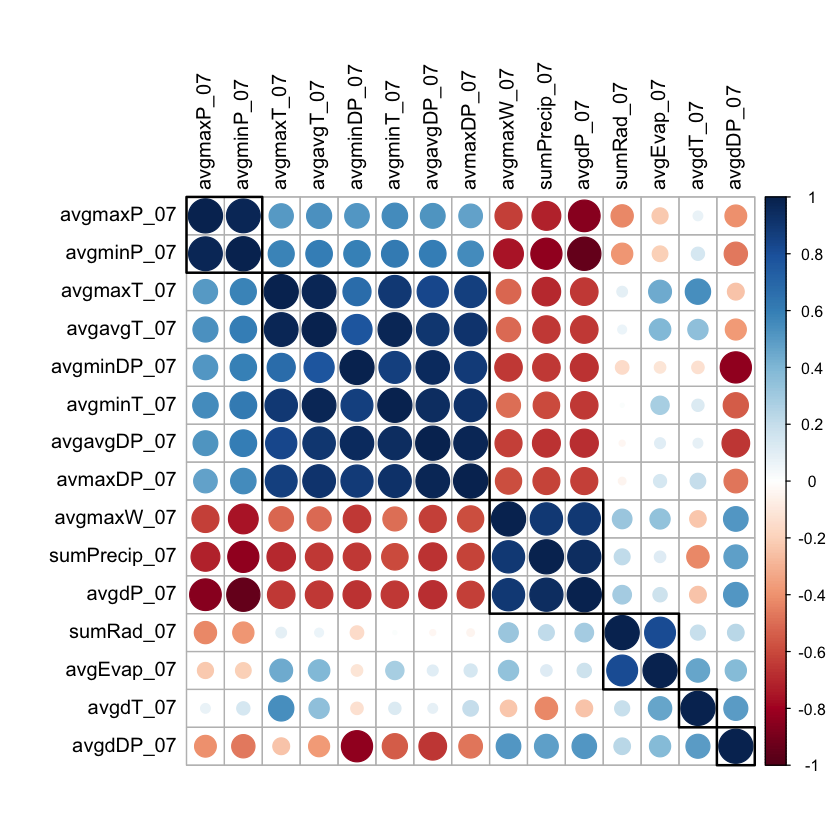

In [39]:
weather_PCA <- new_meta_7 %>% select(avgmaxT_07:avgEvap_07)
x <- cor(weather_PCA)
res1 <- cor.mtest(x, conf.level = 0.95)
# pdf('179_weather_correlations.pdf', height=8, width=8)
  corrplot(
      x, order = 'hclust', addrect = 6, tl.col='black', 
      #col=colorRampPalette(c("magenta4",'white',"royalblue4"))(200)
          )
# dev.off()

## Day of

In [40]:
meta_dayOf <- data.frame(Date=new_meta$Date)
meta_dayOf <- merge(meta_dayOf, weather_df, by='Date')
meta_dayOf <- meta_dayOf %>% select(Date, maxT:totalRad)

x <- cor(meta_dayOf %>% select(-Date))
res1 <- cor.mtest(x, conf.level = 0.95)
pdf('179_weather_correlations_vineid_dayOf.pdf', height=8, width=8)
  corrplot(
      x, order = 'hclust', addrect = 4, tl.col='black', 
      #col=colorRampPalette(c("magenta4",'white',"royalblue4"))(200)
          )
dev.off()

pdf 
  2

In [41]:
# weather_PCA <- prcomp(weather_PCA, center=T, scale=T)
# weather_PCA_plot <- as.data.frame(weather_PCA$x)
# p1 <- ggplot(weather_PCA_plot, aes(x=PC1, y=PC2)) + 
#   geom_point() + 
#   theme_bw()

# p2 <- ggplot(weather_PCA_plot, aes(x=PC1, y=PC3)) + 
#   geom_point() + 
#   theme_bw()

# ggpubr::ggarrange(p1, p2, ncol=2)

In [42]:
# summary(weather_PCA)
# weather_PCA$rotation[, c('PC1', 'PC2', 'PC3', 'PC4', 'PC5')]

## Prepare for Linear Models

In [43]:
vif_meta <- read.csv("vitis_ionomics_meta.csv")
ec_df <- read.csv('1719_ionomics_BACKTRANSFORMED.csv')
ec_df <- merge(ec_df, vif_meta, by.x='X', by.y='samplename')
ec_df$leafpos[which(ec_df$leafpos == 'z')] <- 'Z'
ec_df$samplename <- ec_df$X
ec_df$X <- NULL
ec_df$X.y <- NULL
head(ec_df)

B,Na,Mg,Al,P,S,K,Ca,Fe,Mn,...,year,phenology,row,replicate,cell,leafpos,treatment,block,rootstock,samplename
40.27912,109.99537,2022.016,24.352377,5337.480,1554.516,15616.326,11212.402,85.63071,59.48323,...,2017,anthesis,10,1,A,X,Full,1,3309C,2017_anthesis_10_A_1_X
28.05300,11.49082,1850.242,7.950066,3222.155,1965.940,12411.352,6716.460,65.18279,36.04755,...,2017,anthesis,10,1,A,Y,Full,1,3309C,2017_anthesis_10_A_1_Y
37.54569,10.81767,2716.080,47.946708,2370.230,1619.224,6984.819,20409.482,123.37936,175.24594,...,2017,anthesis,10,1,A,Z,Full,1,3309C,2017_anthesis_10_A_1_Z
43.88419,93.33059,2214.140,28.261224,5716.630,1753.906,15313.964,11580.853,86.35039,66.96620,...,2017,anthesis,10,2,A,X,Full,1,3309C,2017_anthesis_10_A_2_X
24.01623,25.37623,1779.870,99.878800,3309.953,1849.612,12630.998,6064.742,122.84158,44.75406,...,2017,anthesis,10,2,A,Y,Full,1,3309C,2017_anthesis_10_A_2_Y
36.14749,17.30592,2093.658,26.454811,3133.048,1571.082,8868.950,16804.936,73.61102,143.25949,...,2017,anthesis,10,2,A,Z,Full,1,3309C,2017_anthesis_10_A_2_Z


In [44]:
yrPheno2Date <- data.frame(yrPheno = c('2017_anthesis', '2017_veraison', '2017_harvest', 
                                       '2018_anthesis', '2018_veraison', '2018_harvest', 
                                       '2019_anthesis', '2019_veraison', '2019_harvest'),
                          Date = c('2017-05-22', '2017-07-30', '2017-09-25', 
                                   '2018-05-30', '2018-08-01', '2018-09-17', 
                                   '2019-05-23', '2019-08-05', '2019-09-17'))

yrPheno2Date$Date <- as.Date(yrPheno2Date$Date)
yrPheno2Date

yrPheno,Date
2017_anthesis,2017-05-22
2017_veraison,2017-07-30
2017_harvest,2017-09-25
2018_anthesis,2018-05-30
2018_veraison,2018-08-01
2018_harvest,2018-09-17
2019_anthesis,2019-05-23
2019_veraison,2019-08-05
2019_harvest,2019-09-17


In [45]:
ec_df$yrPheno <- paste(ec_df$year, ec_df$phenology, sep='_')
ec_df <- merge(ec_df, yrPheno2Date, by='yrPheno')
head(ec_df)

yrPheno,B,Na,Mg,Al,P,S,K,Ca,Fe,...,phenology,row,replicate,cell,leafpos,treatment,block,rootstock,samplename,Date
2017_anthesis,40.27912,109.99537,2022.016,24.352377,5337.480,1554.516,15616.326,11212.402,85.63071,...,anthesis,10,1,A,X,Full,1,3309C,2017_anthesis_10_A_1_X,2017-05-22
2017_anthesis,28.05300,11.49082,1850.242,7.950066,3222.155,1965.940,12411.352,6716.460,65.18279,...,anthesis,10,1,A,Y,Full,1,3309C,2017_anthesis_10_A_1_Y,2017-05-22
2017_anthesis,37.54569,10.81767,2716.080,47.946708,2370.230,1619.224,6984.819,20409.482,123.37936,...,anthesis,10,1,A,Z,Full,1,3309C,2017_anthesis_10_A_1_Z,2017-05-22
2017_anthesis,43.88419,93.33059,2214.140,28.261224,5716.630,1753.906,15313.964,11580.853,86.35039,...,anthesis,10,2,A,X,Full,1,3309C,2017_anthesis_10_A_2_X,2017-05-22
2017_anthesis,24.01623,25.37623,1779.870,99.878800,3309.953,1849.612,12630.998,6064.742,122.84158,...,anthesis,10,2,A,Y,Full,1,3309C,2017_anthesis_10_A_2_Y,2017-05-22
2017_anthesis,36.14749,17.30592,2093.658,26.454811,3133.048,1571.082,8868.950,16804.936,73.61102,...,anthesis,10,2,A,Z,Full,1,3309C,2017_anthesis_10_A_2_Z,2017-05-22


In [46]:
ec_df$yrPheno <- factor(ec_df$yrPheno, levels=c('2017_anthesis', '2017_veraison', '2017_harvest',
                                                '2018_anthesis', '2018_veraison', '2018_harvest',
                                                '2019_anthesis', '2019_veraison', '2019_harvest'))
ec_df$phenology <- factor(ec_df$phenology, levels=c('anthesis', 'veraison', 'harvest'))
ec_df$year <- as.factor(ec_df$year)
ec_df$vine_id <- paste(ec_df$row, ec_df$cell, ec_df$replicate) 

## Linear Models 

In [47]:
ec_df

yrPheno,B,Na,Mg,Al,P,S,K,Ca,Fe,...,row,replicate,cell,leafpos,treatment,block,rootstock,samplename,Date,vine_id
2017_anthesis,40.27912,109.995367,2022.016,24.352377,5337.480,1554.5158,15616.326,11212.402,85.63071,...,10,1,A,X,Full,1,3309C,2017_anthesis_10_A_1_X,2017-05-22,10 A 1
2017_anthesis,28.05300,11.490818,1850.242,7.950066,3222.155,1965.9401,12411.352,6716.460,65.18279,...,10,1,A,Y,Full,1,3309C,2017_anthesis_10_A_1_Y,2017-05-22,10 A 1
2017_anthesis,37.54569,10.817666,2716.080,47.946708,2370.230,1619.2239,6984.819,20409.482,123.37936,...,10,1,A,Z,Full,1,3309C,2017_anthesis_10_A_1_Z,2017-05-22,10 A 1
2017_anthesis,43.88419,93.330586,2214.140,28.261224,5716.630,1753.9062,15313.964,11580.853,86.35039,...,10,2,A,X,Full,1,3309C,2017_anthesis_10_A_2_X,2017-05-22,10 A 2
2017_anthesis,24.01623,25.376231,1779.870,99.878800,3309.953,1849.6119,12630.998,6064.742,122.84158,...,10,2,A,Y,Full,1,3309C,2017_anthesis_10_A_2_Y,2017-05-22,10 A 2
2017_anthesis,36.14749,17.305920,2093.658,26.454811,3133.048,1571.0825,8868.950,16804.936,73.61102,...,10,2,A,Z,Full,1,3309C,2017_anthesis_10_A_2_Z,2017-05-22,10 A 2
2017_anthesis,36.77627,59.671457,2435.340,19.327588,5911.446,1784.5045,14779.928,12724.465,78.47190,...,10,3,A,X,Full,1,3309C,2017_anthesis_10_A_3_X,2017-05-22,10 A 3
2017_anthesis,22.26756,13.575815,1746.829,4.907601,3023.521,1537.2523,11598.014,6901.323,61.90966,...,10,3,A,Y,Full,1,3309C,2017_anthesis_10_A_3_Y,2017-05-22,10 A 3
2017_anthesis,37.37767,28.171912,2572.907,14.711407,2868.619,1885.1034,7547.819,19375.682,63.04140,...,10,3,A,Z,Full,1,3309C,2017_anthesis_10_A_3_Z,2017-05-22,10 A 3
2017_anthesis,34.37377,118.471808,1713.786,26.154601,5180.784,1817.3610,14504.231,7226.829,82.80144,...,10,4,A,X,Full,1,3309C,2017_anthesis_10_A_4_X,2017-05-22,10 A 4


In [48]:
get_REML <- function(d, meta){
    df <- data.frame(conc=d, leafpos=meta$leafpos, vine_id=meta$vine_id)
    lmod <- lmer(conc ~ (1|leafpos) + (1|vine_id),  data=df)
    return(resid(lmod))
}

x <- apply(X=select(ec_df, B:Cd), FUN=get_REML, MARGIN=2, meta=ec_df)
x <- as.data.frame(x)
x <- apply(X=x, MARGIN=2, FUN=scale)
x <- as.data.frame(x)
x$block <- ec_df$block
x$rootstock <- ec_df$rootstock

x$yrPheno <- ec_df$yrPheno
x <- merge(x, yrPheno2Date, by='yrPheno')

x <- x %>%
  group_by(Date, block, rootstock) %>%
  summarize_at(vars(B:Cd), ~ mean(.x))

x <- merge(x, new_meta, by='Date')
x <-  merge(x, new_meta_7, by='Date')
x <-  merge(x, new_meta_3, by='Date')
x <- merge(x, meta_dayOf, by='Date')
#x <- merge(x, weather_df, by='Date')
colnames(x)

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00206052 (tol = 0.002, component 1)”boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00214709 (tol = 0.002, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00261638 (tol = 0.002, component 1)”boundary (singular) fit: see ?isSingular


[1] "Date"         "block"        "rootstock"    "B"            "Na"          
 [6] "Mg"           "Al"           "P"            "S"            "K"           
[11] "Ca"           "Fe"           "Mn"           "Co"           "Ni"          
[16] "Cu"           "Zn"           "As"           "Se"           "Rb"          
[21] "Sr"           "Mo"           "Cd"           "avgmaxT_14"   "avgminT_14"  
[26] "avgavgT_14"   "avgmaxW_14"   "sumPrecip_14" "avgmaxP_14"   "avgminP_14"  
[31] "avgavgDP_14"  "avmaxDP_14"   "avgminDP_14"  "sumRad_14"    "avgdT_14"    
[36] "avgdP_14"     "avgdDP_14"    "avgEvap_14"   "avgmaxT_07"   "avgminT_07"  
[41] "avgavgT_07"   "avgmaxW_07"   "sumPrecip_07" "avgmaxP_07"   "avgminP_07"  
[46] "avgavgDP_07"  "avmaxDP_07"   "avgminDP_07"  "sumRad_07"    "avgdT_07"    
[51] "avgdP_07"     "avgdDP_07"    "avgEvap_07"   "avgmaxT_03"   "avgminT_03"  
[56] "avgavgT_03"   "avgmaxW_03"   "sumPrecip_03" "avgmaxP_03"   "avgminP_03"  
[61] "avgavgDP_03"  "avmaxDP_03"   "avgminDP_03"  "sumRad_03"    "avgdT_03"    
[66] "avgdP_03"     "avgdDP_03"    "avgEvap_03"   "maxT"         "minT"        
[71] "avgT"         "maxWind"      "precip"       "maxP"         "minP"        
[76] "avgDP"        "maxDP"        "minDP"        "evap"         "totalRad"

In [49]:
lmod <- lm(Ni ~ rootstock*evap, x)
car::Anova(lmod, type=3)
pairs(emmeans::emtrends(lmod, var='evap'))

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


,Sum Sq,Df,F value,Pr(>F)
(Intercept),37.715740,1,157.304657,3.055590e-27
rootstock,4.211725,3,5.855416,7.396250e-04
evap,38.434349,1,160.301829,1.299449e-27
rootstock:evap,4.763726,3,6.622843,2.706566e-04
Residuals,49.870577,208,NA,NA


 contrast                                            estimate    SE  df t.ratio
 1103P,4.26455555555556 - 3309C,4.26455555555556      -0.0466 0.145 208 -0.322 
 1103P,4.26455555555556 - SO4,4.26455555555556        -0.5816 0.145 208 -4.011 
 1103P,4.26455555555556 - Ungrafted,4.26455555555556  -0.2127 0.145 208 -1.467 
 3309C,4.26455555555556 - SO4,4.26455555555556        -0.5349 0.145 208 -3.689 
 3309C,4.26455555555556 - Ungrafted,4.26455555555556  -0.1660 0.145 208 -1.145 
 SO4,4.26455555555556 - Ungrafted,4.26455555555556     0.3689 0.145 208  2.544 
 p.value
 0.9885 
 0.0005 
 0.4594 
 0.0016 
 0.6620 
 0.0562 

P value adjustment: tukey method for comparing a family of 4 estimates 

In [50]:
models <- list()
anovas <- list()
rootstock_p <- c()
term_p <- c()
interaction_p <- c()
ds <- list()

term_PVE <- c()
interaction_PVE <- c()


ions <- colnames(select(x, B:Cd))
terms <- c('avgdDP_14', 'sumPrecip_14', 'avgmaxP_14', 'avgavgT_14', 'avgEvap_14', 'avgdT_14', 
           'avgdDP_07', 'sumPrecip_07', 'avgmaxP_07', 'avgavgT_07', 'avgEvap_07', 'avgdT_07', 
           'avgdDP_03', 'sumPrecip_03', 'avgmaxP_03', 'avgavgT_03', 'avgEvap_03', 'avgdT_03',
           'evap', 'maxP', 'avgT', 'precip')

for (term in terms){
    for (ion in ions){
        d <- x[, c(ion, 'rootstock', term)]
        colnames(d) <- c('ion', 'rootstock', 'term')
        
        # fit model, anova
        lmod <- lm(ion~rootstock*term, d)
        lmod_anova <- car::Anova(lmod, type=3)
        
        # PVE
        SS <- lmod_anova$Sum[2:dim(lmod_anova)[1]]
        PVE <- SS / sum(SS)
        t_PVE <- PVE[2]
        rt_PVE <- PVE[3]
        
        # store outputs
        list_idx <- str_interp("${ion}_${term}")
        models[[list_idx]] <- lmod
        anovas[[list_idx]] <- lmod_anova
        rootstock_p <- c(rootstock_p, lmod_anova$Pr[2])
        term_p <- c(term_p, lmod_anova$Pr[3])
        interaction_p <- c(interaction_p, lmod_anova$Pr[4])
        term_PVE <- c(term_PVE, t_PVE)
        interaction_PVE <- c(interaction_PVE, rt_PVE)
        ds[[list_idx]] <- d
        
    }
}

#p.mat
p.vals <- c(rootstock_p, term_p, interaction_p)
p.mat <- data.frame(p.values=p.vals, p.adjust=p.adjust(p.vals, method='fdr'))
p.mat$model <- rep(names(anovas), 3)
p.mat$term <- c(rep('rootstock', length(ions)*length(terms)), 
                rep('term', length(ions)*length(terms)), 
                rep('interaction', length(ions)*length(terms)))
write.csv(p.mat, '1719_weatherInteractions_vineid.csv')

#PVE.mat
PVE.mat <- data.frame(PVE=c(term_PVE, interaction_PVE),
                      ion=rep(ions, length(terms)),
                      term=c(rep(terms, each=length(ions)),
                             rep(paste('rs', terms, sep='_'), each=length(ions))))

head(PVE.mat)

PVE,ion,term
0.105352208,B,avgdDP_14
0.002143389,Na,avgdDP_14
0.153250181,Mg,avgdDP_14
0.025115715,Al,avgdDP_14
0.513260013,P,avgdDP_14
0.003395857,S,avgdDP_14


In [51]:
head(p.mat)

p.values,p.adjust,model,term
0.6564036,0.9997509,B_avgdDP_14,rootstock
0.8080884,0.9997509,Na_avgdDP_14,rootstock
0.2825982,0.7892489,Mg_avgdDP_14,rootstock
0.9782614,0.9997509,Al_avgdDP_14,rootstock
0.8115104,0.9997509,P_avgdDP_14,rootstock
0.5086489,0.9997509,S_avgdDP_14,rootstock


In [52]:
levels(PVE.mat$term)

[1] "avgavgT_03"      "avgavgT_07"      "avgavgT_14"      "avgdDP_03"      
 [5] "avgdDP_07"       "avgdDP_14"       "avgdT_03"        "avgdT_07"       
 [9] "avgdT_14"        "avgEvap_03"      "avgEvap_07"      "avgEvap_14"     
[13] "avgmaxP_03"      "avgmaxP_07"      "avgmaxP_14"      "avgT"           
[17] "evap"            "maxP"            "precip"          "rs_avgavgT_03"  
[21] "rs_avgavgT_07"   "rs_avgavgT_14"   "rs_avgdDP_03"    "rs_avgdDP_07"   
[25] "rs_avgdDP_14"    "rs_avgdT_03"     "rs_avgdT_07"     "rs_avgdT_14"    
[29] "rs_avgEvap_03"   "rs_avgEvap_07"   "rs_avgEvap_14"   "rs_avgmaxP_03"  
[33] "rs_avgmaxP_07"   "rs_avgmaxP_14"   "rs_avgT"         "rs_evap"        
[37] "rs_maxP"         "rs_precip"       "rs_sumPrecip_03" "rs_sumPrecip_07"
[41] "rs_sumPrecip_14" "sumPrecip_03"    "sumPrecip_07"    "sumPrecip_14"

In [53]:
PVE.mat$ion <- factor(PVE.mat$ion, levels=rev(sort(ions)))
PVE.mat$term <- factor(PVE.mat$term, 
                       levels=c('avgavgT_14', 'avgdDP_14', 'avgdT_14', 'avgEvap_14', 
                                'avgmaxP_14', 'sumPrecip_14',
                                'rs_avgavgT_14', 'rs_avgdDP_14', 'rs_avgdT_14', 'rs_avgEvap_14', 
                                'rs_avgmaxP_14', 'rs_sumPrecip_14',
                                
                                'avgavgT_07', 'avgdDP_07', 'avgdT_07', 'avgEvap_07', 
                                'avgmaxP_07', 'sumPrecip_07',
                                'rs_avgavgT_07', 'rs_avgdDP_07', 'rs_avgdT_07', 'rs_avgEvap_07', 
                                'rs_avgmaxP_07', 'rs_sumPrecip_07',
                                
                                'avgavgT_03', 'avgdDP_03', 'avgdT_03', 'avgEvap_03', 
                                'avgmaxP_03', 'sumPrecip_03',
                                'rs_avgavgT_03', 'rs_avgdDP_03', 'rs_avgdT_03', 'rs_avgEvap_03', 
                                'rs_avgmaxP_03', 'rs_sumPrecip_03',
                                
                                
                                'avgT', 'evap', 'maxP', 'precip',
                                'rs_avgT', 'rs_evap', 'rs_maxP', 'rs_precip'))
                       
                       
#                        levels=c('avgdDP', 'sumPrecip', 'avgavgT', 
#                                 'sumRad', 'avgdT', 'evap',
#                                 'rs_avgdDP', 'rs_sumPrecip', 'rs_avgavgT', 
#                                 'rs_sumRad', 'rs_avgdT', 'rs_evap'),
                       
#                        labels=c('dDP', 'sumPrecip', 'avgT', 'sumRad', 'dT', 'Evap',  
#                                 'rs_dDP', 'rs_sumPrecip', 'rs_avgT', 'rs_sumRad', 'rs_dT', 'rs_Evap'))

In [54]:
pdf("1719_weatherModels_vineid.pdf", height=6, width=12)
ggplot(PVE.mat, aes(x=term, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=14), 
        axis.title=element_text(size=12, face="bold"),
        legend.position = "bottom")
dev.off()

pdf 
  2

In [55]:
PVE.mat_copy <- PVE.mat
p.mat_filt <- p.mat[p.mat$term != 'rootstock',]
head(p.mat_filt)

PVE.mat_copy$PVE[which(p.mat_filt$p.adjust > 0.05)] <- NA 
PVE.mat_copy <- na.omit(PVE.mat_copy)


pdf("1719_weatherModels_pval_vineid.pdf", height=8, width=42)
ggplot(PVE.mat_copy, aes(x=term, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=12), 
        axis.title=element_blank(),
        legend.position = "bottom")
dev.off()

,p.values,p.adjust,model,term
441,1.246923e-06,1.016011e-05,B_avgdDP_14,term
442,5.027892e-01,9.997509e-01,Na_avgdDP_14,term
443,2.512306e-09,2.786759e-08,Mg_avgdDP_14,term
444,2.147712e-02,9.057445e-02,Al_avgdDP_14,term
445,1.118165e-34,2.951957e-32,P_avgdDP_14,term
446,3.965532e-01,9.895090e-01,S_avgdDP_14,term


pdf 
  2

In [56]:
PVE.mat_copy_filt <- PVE.mat_copy[!str_detect(PVE.mat_copy$term, "_14$"), ]
PVE.mat_copy_filt <- PVE.mat_copy_filt[!str_detect(PVE.mat_copy_filt$term, "_03$"), ]

dim(PVE.mat_copy)
dim(PVE.mat_copy_filt)

PVE.mat_copy_filt$term <- droplevels(PVE.mat_copy_filt$term)

[1] 285   3

[1] 129   3

In [57]:
pdf("1719_weatherModels_pval_vineid_subset.pdf", height=8, width=18)
ggplot(PVE.mat_copy_filt, aes(x=term, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=12), 
        axis.title=element_blank(),
        legend.position = "bottom")
dev.off()

pdf 
  2

In [60]:
PVE.mat_copy_filt_07 <- PVE.mat_copy_filt[str_detect(PVE.mat_copy_filt$term, "_07$"), ]

pdf("1719_weatherModels_pval_vineid_subset_07.pdf", height=8, width=8)
ggplot(PVE.mat_copy_filt_07, aes(x=term, y=ion, fill=PVE*100)) + 
  geom_tile(color='white', size=0.5) + 
  scale_fill_viridis_c(option='inferno', direction=-1, na.value = "transparent") + 
  labs(x = "Factor", y="") +
  scale_x_discrete(position='top') +
  #ggpubr::theme_classic2() + 
  theme_minimal() + 
  theme(axis.text=element_text(size=12), 
        axis.title=element_blank(),
        legend.position = "bottom")
dev.off()

pdf 
  2

In [179]:
p.mat[p.mat$p.adjust <= 0.05 & p.mat$term=='term', ]
p.mat[p.mat$p.adjust <= 0.05 & p.mat$term=='interaction', ]

,p.values,p.adjust,model,term
441,1.246923e-06,1.016011e-05,B_avgdDP_14,term
443,2.512306e-09,2.786759e-08,Mg_avgdDP_14,term
445,1.118165e-34,2.951957e-32,P_avgdDP_14,term
447,7.163380e-07,6.100427e-06,K_avgdDP_14,term
449,5.163278e-04,2.912618e-03,Fe_avgdDP_14,term
450,3.404883e-09,3.654021e-08,Mn_avgdDP_14,term
451,4.783804e-23,1.913522e-21,Co_avgdDP_14,term
452,3.199256e-04,1.902260e-03,Ni_avgdDP_14,term
453,4.346451e-27,2.868658e-25,Cu_avgdDP_14,term
454,1.003020e-08,1.026346e-07,Zn_avgdDP_14,term


,p.values,p.adjust,model,term
891,0.0105466976,0.0473525199,Co_avgdDP_14,interaction
911,0.0073582655,0.0340803878,Co_sumPrecip_14,interaction
931,0.0019939678,0.0100844351,Co_avgmaxP_14,interaction
939,0.0006872884,0.0038118517,Mo_avgmaxP_14,interaction
951,0.0080908354,0.0370829956,Co_avgavgT_14,interaction
1031,0.0056158819,0.0264748719,Co_sumPrecip_07,interaction
1036,0.0021811769,0.0109891353,Se_sumPrecip_07,interaction
1051,0.0005104642,0.0028919001,Co_avgmaxP_07,interaction
1059,0.0001904141,0.0011690540,Mo_avgmaxP_07,interaction
1151,0.0056153639,0.0264748719,Co_sumPrecip_03,interaction


In [180]:
calc_PVE <- function(x){
    SS <- x$Sum[2:dim(x)[1]]
    output <- SS / sum(SS)
    return (output)
}

PVE <- as.data.frame(lapply(X=anovas, FUN=calc_PVE))
d <- anovas[['B_avgdDP_14']]
rownames(PVE) <- rownames(d)[2:dim(d)[1]]
PVE
#sanity check
# colSums(PVE)

,B_avgdDP_14,Na_avgdDP_14,Mg_avgdDP_14,Al_avgdDP_14,P_avgdDP_14,S_avgdDP_14,K_avgdDP_14,Ca_avgdDP_14,Fe_avgdDP_14,Mn_avgdDP_14,...,Co_precip,Ni_precip,Cu_precip,Zn_precip,As_precip,Se_precip,Rb_precip,Sr_precip,Mo_precip,Cd_precip
rootstock,0.006823020,0.004621920,0.0151377,0.0009143535,0.002210580,0.010951944,0.003274528,0.002211821,0.002755946,0.003578585,...,0.008068577,0.009242598,0.026876518,0.002828109,0.0212607944,0.00506289,0.021430284,0.0106079126,0.003588123,0.008831937
term,0.105352208,0.002143389,0.1532502,0.0251157146,0.513260013,0.003395857,0.111094310,0.026493709,0.056216688,0.153935512,...,0.100135183,0.009144691,0.364101089,0.000212516,0.0009834276,0.01064640,0.180759913,0.0043669434,0.008369806,0.110797023
rootstock:term,0.009380382,0.003858910,0.0110013,0.0008669061,0.004321956,0.006980623,0.001862738,0.002189610,0.001264733,0.003006832,...,0.031903462,0.008013595,0.004373465,0.005104034,0.0049480647,0.07492061,0.003834006,0.0006904968,0.010521697,0.011639461
Residuals,0.878444390,0.989375781,0.8206108,0.9731030258,0.480207452,0.978671575,0.883768424,0.969104859,0.939762633,0.839479070,...,0.859892779,0.973599115,0.604648928,0.991855342,0.9728077133,0.90937010,0.793975798,0.9843346471,0.977520374,0.868731579


In [186]:
rev(sort(PVE['term', str_detect(colnames(PVE), '_07$')]))[1:20]
rev(sort(PVE['rootstock:term', !(str_detect(colnames(PVE), '_14$') | str_detect(colnames(PVE), '_03$'))]))[1:20]

,P_sumPrecip_07,Rb_avgmaxP_07,Cu_avgmaxP_07,Cu_sumPrecip_07,P_avgmaxP_07,Rb_sumPrecip_07,Cd_avgmaxP_07,Cd_sumPrecip_07,Mo_avgmaxP_07,Fe_sumPrecip_07,Mn_avgdT_07,K_sumPrecip_07,B_avgmaxP_07,Co_avgdDP_07,Ni_avgdDP_07,Mg_avgmaxP_07,Fe_avgdT_07,B_sumPrecip_07,P_avgdDP_07,Zn_avgdDP_07
term,0.6464477,0.5629113,0.5167929,0.498768,0.4858715,0.4636522,0.3980089,0.3948009,0.3416369,0.3264015,0.3181494,0.3152877,0.300997,0.2476568,0.2374219,0.2369417,0.2338431,0.2299031,0.2265532,0.2233783


,Se_precip,Co_avgmaxP_07,Se_sumPrecip_07,Mo_avgmaxP_07,Mo_avgT,Ni_evap,Co_sumPrecip_07,Se_avgmaxP_07,Co_avgavgT_07,Co_precip,Co_avgT,Mo_avgEvap_07,Se_avgT,Mo_avgdDP_07,Co_avgdDP_07,Se_avgEvap_07,S_avgdDP_07,Se_maxP,B_avgT,Ni_avgEvap_07
rootstock:term,0.07492061,0.07451391,0.06629165,0.05458953,0.05145161,0.04896903,0.04795261,0.03772966,0.03718471,0.03190346,0.02597336,0.02587441,0.0219965,0.02157671,0.02126329,0.02051369,0.01852501,0.01650369,0.01640045,0.01627474


In [92]:
x_ni <- x %>% select(P, Rb, Mn, Co, sumPrecip_07, avgmaxP_07, avgdT_07, avgdDP_07, block)

p1 <- ggplot(x_ni, aes(x=sumPrecip_07, y=scale(P))) +  
  stat_smooth(method='lm', color='grey15', fill='grey25') + 
  geom_point(size=4, shape=21, color='grey15', fill='grey95', stroke=1.1) +
  ylab("Phosphorus Z-Score") + 
  xlab("Cummulative Precipitation (mm)") + 
  theme_bw()

p2 <- ggplot(x_ni, aes(x=avgmaxP_07, y=scale(Rb))) +  
  stat_smooth(method='lm', color='grey15', fill='grey25') + 
  geom_point(size=4, shape=21, color='grey15', fill='grey95', stroke=1.1) +
  ylab("Rubidium Z-Score") + 
  xlab("Average Maximum Pressure (MB)") +
  theme_bw()

p3 <- ggplot(x_ni, aes(x=avgdT_07, y=scale(Mn))) +  
  stat_smooth(method='lm', color='grey15', fill='grey25') + 
  geom_point(size=4, shape=21, color='grey15', fill='grey95', stroke=1.1) +
  ylab("Manganese Z-Score") + 
  xlab("Average Daily Change in Temp (C)") + 
  theme_bw()

p4 <- ggplot(x_ni, aes(x=avgdDP_07, y=scale(Co))) +  
  stat_smooth(method='lm', color='grey15', fill='grey25') + 
  geom_point(size=4, shape=21, color='grey15', fill='grey95', stroke=1.1) +
  ylab("Cobalt Z-Score") + 
  xlab("Average Daily Change in Dew Point (C)") +
  theme_bw()

pdf("final_run/1719_weatherMainEffect_vineid.pdf", height=10.6, width=10.6)
  ggpubr::ggarrange(p1, p2, p3, p4, nrow=2, ncol=2)
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


pdf 
  2

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


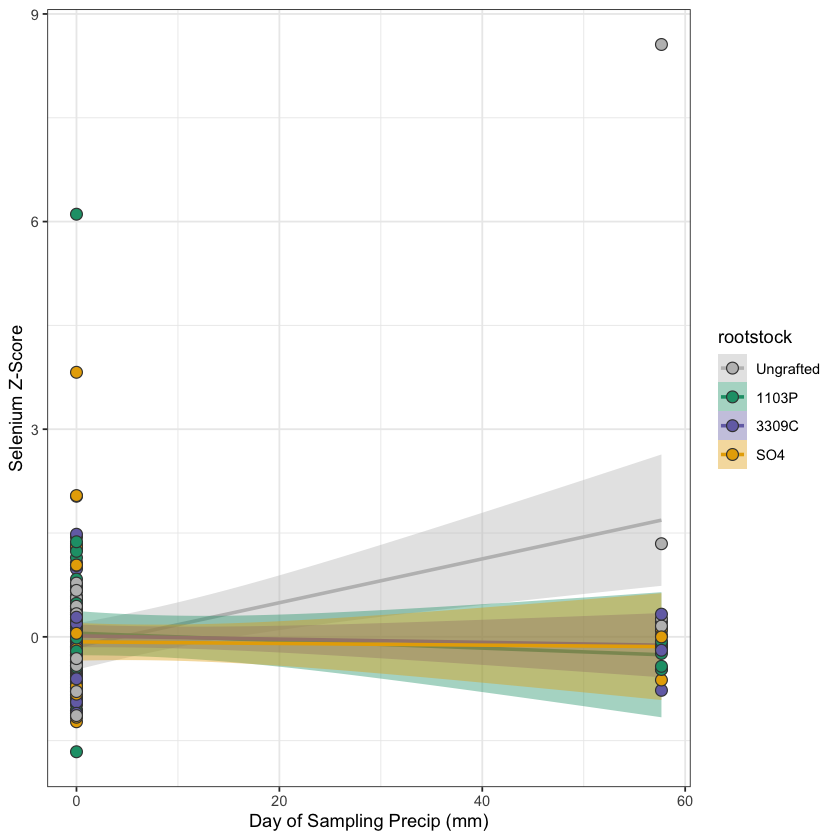

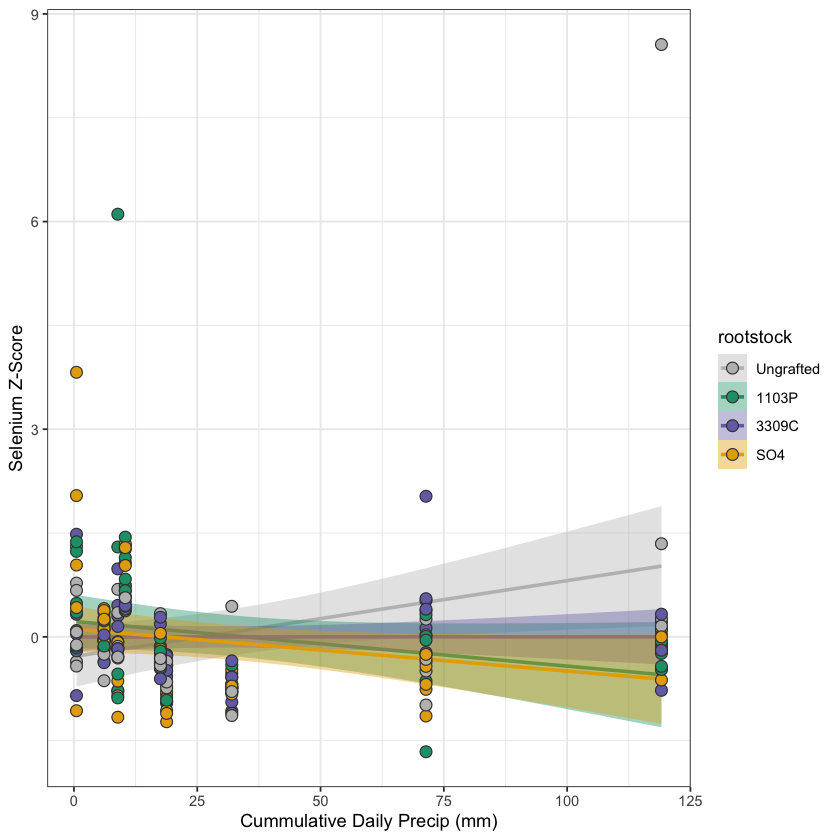

In [190]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
x_ni <- x %>% select(Date, Se, precip, sumPrecip_07, rootstock, block)
x_ni$rootstock <- factor(x_ni$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))


ggplot(x_ni, aes(x=precip, y=scale(Se), fill=rootstock)) + 
  geom_smooth(aes(color=rootstock), method='lm') + 
  scale_color_manual(values=rs_palette) + 
  geom_point(size=4, shape=21, color='grey25') + 
  scale_fill_manual(values=rs_palette) + 
  ylab("Selenium Z-Score") + 
  xlab("Day of Sampling Precip (mm)") +
  theme_bw()

ggplot(x_ni, aes(x=sumPrecip_07, y=scale(Se), fill=rootstock)) + 
  geom_smooth(aes(color=rootstock), method='lm') + 
  scale_color_manual(values=rs_palette) + 
  geom_point(size=4, shape=21, color='grey25') + 
  scale_fill_manual(values=rs_palette) + 
  ylab("Selenium Z-Score") + 
  xlab("Cummulative Daily Precip (mm)") +
  theme_bw()

In [94]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
x_ni <- x %>% select(Date, Co, Se, Mo, Ni, avgmaxP_07, sumPrecip_07, avgT, evap, rootstock, block)
x_ni$rootstock <- factor(x_ni$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))

p5 <- ggplot(x_ni, aes(x=avgmaxP_07, y=scale(Co), fill=rootstock)) + 
  geom_smooth(aes(color=rootstock), method='lm') + 
  scale_color_manual(values=rs_palette) + 
  geom_point(size=4, shape=21, color='grey25', stroke=1.1) + 
  scale_fill_manual(values=rs_palette) + 
  ylab("Cobalt Z-Score") + 
  xlab("Average Daily Max Pressure (MB)") +
  theme_bw()

# p6 <- ggplot(x_ni, aes(x=sumPrecip_07, y=scale(Se), fill=rootstock)) + 
#   geom_smooth(aes(color=rootstock), method='lm') + 
#   scale_color_manual(values=rs_palette) + 
#   geom_point(size=3, shape=21, color='grey25') + 
#   scale_fill_manual(values=rs_palette) + 
#   ylab("Selenium Z-Score") + 
#   xlab("Cummulative Precipitation (mm)") +
#   theme_bw()

# p7 <- ggplot(x_ni, aes(x=avgT, y=scale(Mo), fill=rootstock)) + 
#   geom_smooth(aes(color=rootstock), method='lm') + 
#   scale_color_manual(values=rs_palette) + 
#   geom_point(size=3, shape=21, color='grey25') + 
#   scale_fill_manual(values=rs_palette) + 
#   ylab("Molybdenum Z-Score") + 
#   xlab("Day of Sampling Change in Temp (C)") +
#   theme_bw()

p8 <- ggplot(x_ni, aes(x=evap, y=scale(Ni), fill=rootstock)) + 
  geom_smooth(aes(color=rootstock), method='lm') + 
  scale_color_manual(values=rs_palette) + 
  geom_point(size=4, shape=21, color='grey25', stroke=1.1) + 
  scale_fill_manual(values=rs_palette) + 
  ylab("Nickel Z-Score") + 
  xlab("Day of Sampling Evapotranspiration (mm)") +
  theme_bw()



pdf("final_run/1719_weatherRootstock_vineid.pdf", height=5.3, width=10.6)
  ggpubr::ggarrange(p5, p8,  
                    ncol=2, nrow=1, 
                    common.legend=T, legend='bottom')
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


pdf 
  2

In [195]:
p_filter <- 0.05 / 4

In [205]:
x_posthoc <- emmeans::emtrends(models[['Co_avgmaxP_07']], var='term', data=ds[['Co_avgmaxP_07']])
as.data.frame(x_posthoc)

x_posthoc <- as.data.frame(pairs(x_posthoc))
x_posthoc

x_posthoc[x_posthoc$p.value < p_filter,]

rootstock,term,term.trend,SE,df
1103P,1018.167,-1.366590e-01,0.03453922,208
3309C,1018.167,-4.613392e-05,0.03453922,208
SO4,1018.167,6.854472e-02,0.03453922,208
Ungrafted,1018.167,-3.648211e-02,0.03453922,208


contrast,estimate,SE,df,t.ratio,p.value
"1103P,1018.16666666667 - 3309C,1018.16666666667",-0.13661282,0.04884583,208,-2.7968165,0.0286456025
"1103P,1018.16666666667 - SO4,1018.16666666667",-0.20520367,0.04884583,208,-4.2010480,0.0002293586
"1103P,1018.16666666667 - Ungrafted,1018.16666666667",-0.10017685,0.04884583,208,-2.0508782,0.1729646641
"3309C,1018.16666666667 - SO4,1018.16666666667",-0.06859085,0.04884583,208,-1.4042315,0.4981209374
"3309C,1018.16666666667 - Ungrafted,1018.16666666667",0.03643598,0.04884583,208,0.7459383,0.8783135276
"SO4,1018.16666666667 - Ungrafted,1018.16666666667",0.10502683,0.04884583,208,2.1501698,0.1409125625


,contrast,estimate,SE,df,t.ratio,p.value
2,"1103P,1018.16666666667 - SO4,1018.16666666667",-0.2052037,0.04884583,208,-4.201048,0.0002293586


In [206]:
x_posthoc <- emmeans::emtrends(models[['Se_sumPrecip_07']], var='term', data=ds[['Se_sumPrecip_07']])
as.data.frame(x_posthoc)

x_posthoc <- as.data.frame(pairs(x_posthoc))
x_posthoc

x_posthoc[x_posthoc$p.value < p_filter,]

rootstock,term,term.trend,SE,df
1103P,31.63667,-1.226262e-03,0.0006880433,208
3309C,31.63667,3.657033e-06,0.0006880433,208
SO4,31.63667,-1.153224e-03,0.0006880433,208
Ungrafted,31.63667,2.082269e-03,0.0006880433,208


contrast,estimate,SE,df,t.ratio,p.value
"1103P,31.6366666666667 - 3309C,31.6366666666667",-0.0012299194,0.0009730402,208,-1.26399657,0.586883889
"1103P,31.6366666666667 - SO4,31.6366666666667",-0.0000730386,0.0009730402,208,-0.07506226,0.999847875
"1103P,31.6366666666667 - Ungrafted,31.6366666666667",-0.0033085312,0.0009730402,208,-3.40020001,0.004454723
"3309C,31.6366666666667 - SO4,31.6366666666667",0.0011568808,0.0009730402,208,1.18893431,0.634522832
"3309C,31.6366666666667 - Ungrafted,31.6366666666667",-0.0020786118,0.0009730402,208,-2.13620344,0.145129865
"SO4,31.6366666666667 - Ungrafted,31.6366666666667",-0.0032354926,0.0009730402,208,-3.32513775,0.005719413


,contrast,estimate,SE,df,t.ratio,p.value
3,"1103P,31.6366666666667 - Ungrafted,31.6366666666667",-0.003308531,0.0009730402,208,-3.400200,0.004454723
6,"SO4,31.6366666666667 - Ungrafted,31.6366666666667",-0.003235493,0.0009730402,208,-3.325138,0.005719413


In [207]:
x_posthoc <- emmeans::emtrends(models[['Mo_avgT']], var='term', data=ds[['Mo_avgT']])
as.data.frame(x_posthoc)

x_posthoc <- as.data.frame(pairs(x_posthoc))
x_posthoc

x_posthoc[x_posthoc$p.value < p_filter,]

rootstock,term,term.trend,SE,df
1103P,22.6,-0.13731930,0.02719149,208
3309C,22.6,-0.16209836,0.02719149,208
SO4,22.6,-0.18335291,0.02719149,208
Ungrafted,22.6,-0.03640926,0.02719149,208


contrast,estimate,SE,df,t.ratio,p.value
"1103P,22.6 - 3309C,22.6",0.02477905,0.03845457,208,0.6443721,0.917414900
"1103P,22.6 - SO4,22.6",0.04603360,0.03845457,208,1.1970904,0.629371044
"1103P,22.6 - Ungrafted,22.6",-0.10091004,0.03845457,208,-2.6241364,0.045736333
"3309C,22.6 - SO4,22.6",0.02125455,0.03845457,208,0.5527184,0.945728826
"3309C,22.6 - Ungrafted,22.6",-0.12568910,0.03845457,208,-3.2685085,0.006882872
"SO4,22.6 - Ungrafted,22.6",-0.14694365,0.03845457,208,-3.8212268,0.001000973


,contrast,estimate,SE,df,t.ratio,p.value
5,"3309C,22.6 - Ungrafted,22.6",-0.1256891,0.03845457,208,-3.268508,0.006882872
6,"SO4,22.6 - Ungrafted,22.6",-0.1469436,0.03845457,208,-3.821227,0.001000973


In [208]:
x_posthoc <- emmeans::emtrends(models[['Ni_evap']], var='term', data=ds[['Ni_evap']])
as.data.frame(x_posthoc)


x_posthoc <- as.data.frame(pairs(x_posthoc))
x_posthoc

x_posthoc[x_posthoc$p.value < p_filter,]

rootstock,term,term.trend,SE,df
1103P,4.264556,0.4388136,0.1025243,208
3309C,4.264556,0.4854569,0.1025243,208
SO4,4.264556,1.0203646,0.1025243,208
Ungrafted,4.264556,0.6514917,0.1025243,208


contrast,estimate,SE,df,t.ratio,p.value
"1103P,4.26455555555556 - 3309C,4.26455555555556",-0.04664336,0.1449912,208,-0.3216979,0.9884604366
"1103P,4.26455555555556 - SO4,4.26455555555556",-0.58155105,0.1449912,208,-4.0109403,0.0004865173
"1103P,4.26455555555556 - Ungrafted,4.26455555555556",-0.21267810,0.1449912,208,-1.4668345,0.4594369508
"3309C,4.26455555555556 - SO4,4.26455555555556",-0.53490769,0.1449912,208,-3.6892424,0.0016247122
"3309C,4.26455555555556 - Ungrafted,4.26455555555556",-0.16603474,0.1449912,208,-1.1451367,0.6620129206
"SO4,4.26455555555556 - Ungrafted,4.26455555555556",0.36887295,0.1449912,208,2.5441057,0.0562319635


,contrast,estimate,SE,df,t.ratio,p.value
2,"1103P,4.26455555555556 - SO4,4.26455555555556",-0.5815511,0.1449912,208,-4.010940,0.0004865173
4,"3309C,4.26455555555556 - SO4,4.26455555555556",-0.5349077,0.1449912,208,-3.689242,0.0016247122


`geom_smooth()` using formula 'y ~ x'


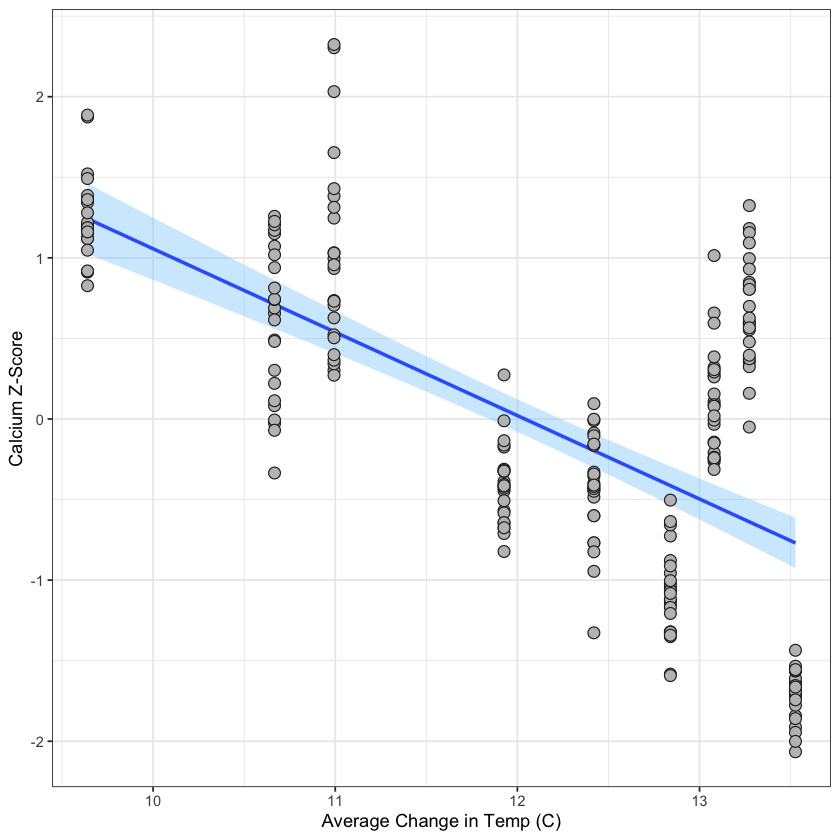

In [44]:
x_ni <- x %>% select(Ca, Mn, Mg, avgavgT, block)

p1 <- ggplot(x_ni, aes(x=avgavgT, y=scale(Ca))) +  
  stat_smooth(method='lm', fill='skyblue1') + 
  geom_point(size=3, shape=21, color='grey15', fill='grey75') +
  ylab("Calcium Z-Score") + 
  xlab("Average Daily Temp (C)") +
  theme_bw()
p2 <- ggplot(x_ni, aes(x=avgavgT, y=scale(Mn))) +  
  stat_smooth(method='lm', fill='skyblue1') + 
  geom_point(size=3, shape=21, color='grey15', fill='grey75') +
  ylab("Manganese Z-Score") + 
  xlab("Average Daily Temp (C)") +
  theme_bw()
p3 <- ggplot(x_ni, aes(x=avgavgT, y=scale(Mg))) +  
  stat_smooth(method='lm', fill='skyblue1') + 
  geom_point(size=3, shape=21, color='grey15', fill='grey75') +
  ylab("Magnesium Z-Score") + 
  xlab("Average Daily Temp (C)") +
  theme_bw()

pdf('1719_ionomics_seasonalMarkers_vineid.pdf', height=4, width=12)
  ggpubr::ggarrange(p1, p2, p3, ncol=3)
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


pdf 
  2

`geom_smooth()` using formula 'y ~ x'


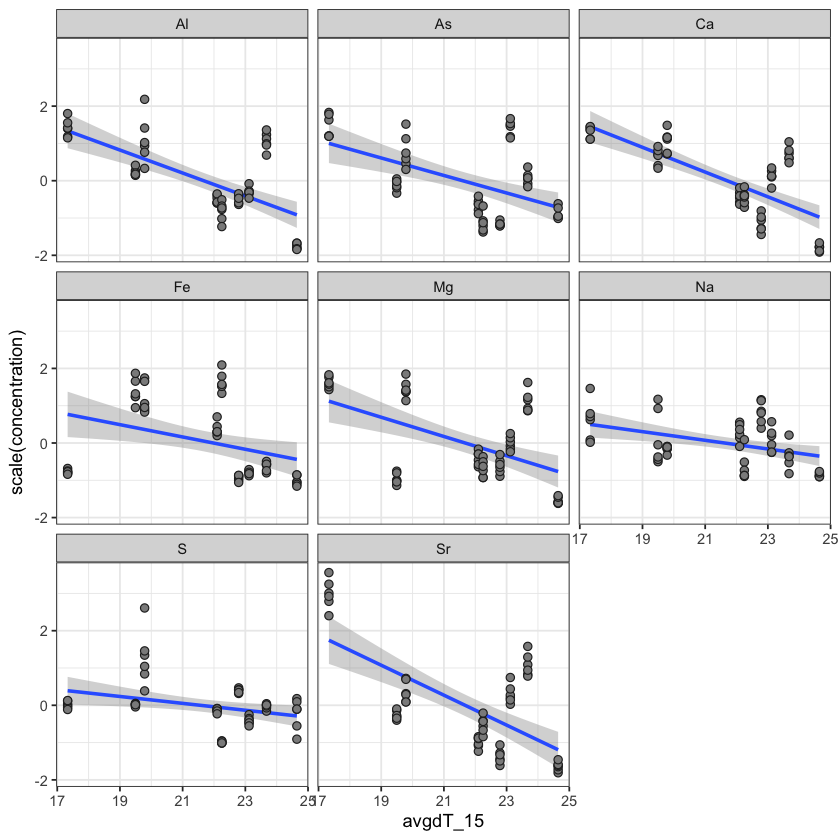

In [63]:
x_plot <- x %>% 
  select(B:Cd, avgdT_15, block) %>% 
  gather(element, concentration, -avgdT_15, -block)

#x_plot <- x_plot[x_plot$element %in% c('Al', 'As', 'Ca', 'Fe', 'Mg', 'Na', 'Rb', 'S', 'Sr') ,] #evap
#x_plot <- x_plot[x_plot$element %in% c('B', 'Cd', 'Cu', 'Mg', 'Mo', 'P', 'Rb', 'Sr') ,] #avgavgT_15
x_plot <- x_plot[x_plot$element %in% c('Al', 'As', 'Ca', 'Fe', 'Mg', 'Na', 'S', 'Sr') ,] #avgdT_15

ggplot(x_plot, aes(x=avgdT_15, y=scale(concentration))) + 
  stat_smooth(method='lm') + 
  geom_point(shape=21, size=2, fill='grey55', color='grey15') + 
  facet_wrap('element') + 
  theme_bw()

In [ ]:
## Rootstock by Env

In [83]:
get_REML_rootstock <- function(d, meta){
    df <- data.frame(conc=d, leafpos=meta$leafpos)
    lmod <- lmer(conc ~ (1|leafpos), data=df)
    return(resid(lmod))
}

x <- apply(X=select(ec_df, B:Cd), FUN=get_REML_rootstock, MARGIN=2, meta=ec_df)
x <- as.data.frame(x)
x <- apply(X=x, MARGIN=2, FUN=scale)
x <- as.data.frame(x)
x$block <- ec_df$block
x$rootstock <- ec_df$rootstock

x$yrPheno <- ec_df$yrPheno
x <- merge(x, yrPheno2Date, by='yrPheno')

x <- x %>%
  group_by(Date, block, rootstock) %>%
  summarize_at(vars(B:Cd), ~ mean(.x))

x <- merge(x, new_meta, by='Date')
x <- merge(x, weather_df, by='Date')
head(x)

Date,block,rootstock,B,Na,Mg,Al,P,S,K,...,precip,maxP,minP,avgDP,maxDP,minDP,evap,csrad,totalRad,MonthDay
2017-05-22,1,1103P,1.0599301,0.47208716,-0.15739856,-0.14098426,1.4352259,-0.09731461,0.63150666,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22
2017-05-22,1,3309C,1.4608916,0.42306652,-0.44934767,-0.08379348,0.7046674,0.07785367,0.63794493,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22
2017-05-22,1,SO4,1.0290787,0.12603190,-0.35839280,-0.34710991,1.5328639,-0.11989713,0.80319661,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22
2017-05-22,1,Ungrafted,0.2450375,0.14978577,0.00219362,-0.28355126,0.7023447,-0.04906786,0.07237146,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22
2017-05-22,2,1103P,1.0714619,0.08258806,-0.19911468,-0.33954046,1.2098859,-0.16111892,0.50724612,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22
2017-05-22,2,3309C,1.1557962,0.45569316,-0.54403910,-0.43074898,0.5605305,0.03474556,0.62580452,...,0,30.15,29.88,49.7,57.6,41.2,0.173,29.75,23.04,1904-05-22


In [119]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
x$rootstock <- factor(x$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))

`geom_smooth()` using formula 'y ~ x'


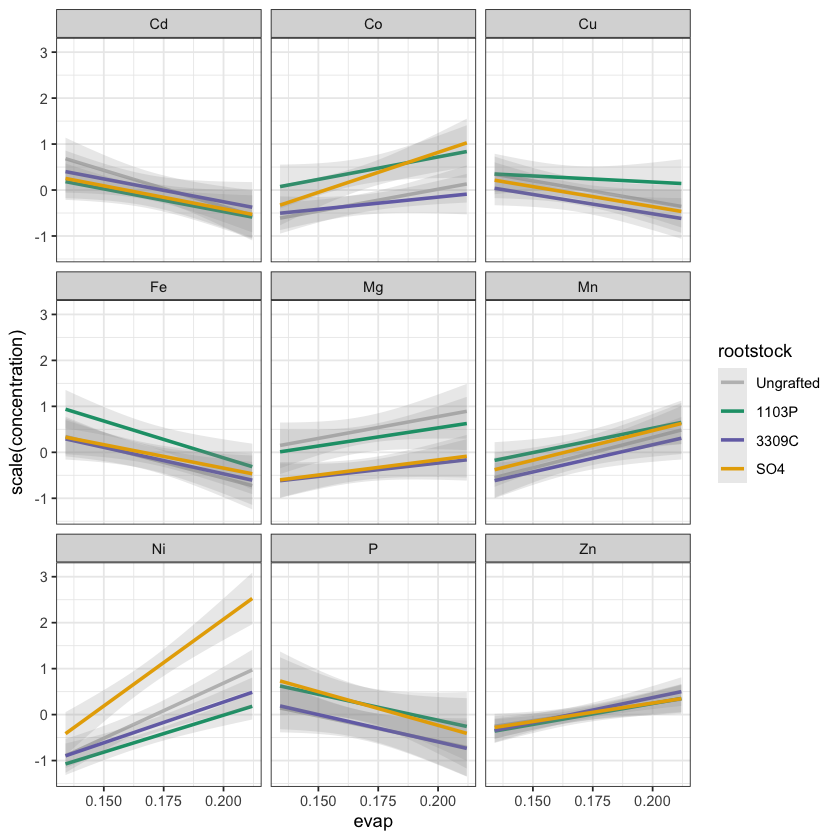

In [120]:
x_plot <- x %>% 
  select(B:Cd, block, evap, rootstock) %>% 
  gather(element, concentration, -evap, -block, -rootstock)

x_plot <- x_plot[x_plot$element %in% c('Cd', 'Co', 'Cu', 'Fe', 'Mg', 'Mn', 'Ni', 'P', 'Zn') ,]
#x_plot <- x_plot[x_plot$element %in% c('B', 'Cd', 'Cu', 'Mg', 'Mo', 'P', 'Rb', 'Sr') ,]
#x_plot <- x_plot[x_plot$element %in% c('Al', 'As', 'Ca', 'Fe', 'Mg', 'Na', 'S', 'Sr') ,] #avgdT_15

ggplot(x_plot, aes(x=evap, y=scale(concentration), group=rootstock, color=rootstock)) + 
  stat_smooth(method='lm', alpha=0.2) + 
  scale_color_manual(values=rs_palette) + 
  #geom_point(shape=21, size=2, fill='grey55', color='grey15') + 
  facet_wrap('element') + 
  theme_bw()

In [116]:
options(contrasts = c("contr.sum","contr.poly"))

In [117]:
lmod <- lm(P ~ rootstock*avgdDP, x)
car::Anova(lmod, type=3)
pairs(emmeans::emtrends(lmod, var='avgdDP'))

,Sum Sq,Df,F value,Pr(>F)
(Intercept),67.4781427,1,216.8268921,4.275754e-34
rootstock,0.2979824,3,0.3191681,8.115104e-01
avgdDP,69.1865773,1,222.3165891,1.118165e-34
rootstock:avgdDP,0.5825923,3,0.6240128,6.002221e-01
Residuals,64.7311482,208,NA,NA


 contrast                                            estimate    SE  df t.ratio
 1103P,6.50740740740741 - 3309C,6.50740740740741       0.1212 0.111 208  1.092 
 1103P,6.50740740740741 - SO4,6.50740740740741        -0.0109 0.111 208 -0.099 
 1103P,6.50740740740741 - Ungrafted,6.50740740740741   0.0688 0.111 208  0.620 
 3309C,6.50740740740741 - SO4,6.50740740740741        -0.1321 0.111 208 -1.191 
 3309C,6.50740740740741 - Ungrafted,6.50740740740741  -0.0523 0.111 208 -0.472 
 SO4,6.50740740740741 - Ungrafted,6.50740740740741     0.0798 0.111 208  0.719 
 p.value
 0.6948 
 0.9997 
 0.9255 
 0.6334 
 0.9652 
 0.8895 

P value adjustment: tukey method for comparing a family of 4 estimates 